In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-weights-of-msff/trained_model_CRC_MSFF(transform).pth
/kaggle/input/model-weights-of-msff/trained_model_CRC_MSFF.pkl
/kaggle/input/model-weights-of-msff/trained_model_CRC_MSFF(transform).pkl
/kaggle/input/model-weights-of-msff/trained_model_CRC_MSFF.pth
/kaggle/input/model-weights-of-msff/trained_model_PathMNIST_MSFF.pkl
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TPWTCDWW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TVEFEGLW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-CFQTHFME.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-EAEVGGDD.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TAYDCYET.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-KHTKNTIW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-KGGQINNF.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-FYEPPFHG.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-VDNKPEAP.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC

In [5]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=922ef0c20b99bfe93f55ebd606d934a96fc5a011cf4df55392c2b78fe48c1d9f
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


# SE Block Model with B0 Encoder

In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()  # b: batch size, c: number of channels
        #print(f"SEBlock input size: {x.size()}")  # Debugging print
        y = torch.mean(x, dim=(2, 3))  # Global Average Pooling, shape: (b, c)
        y = self.fc1(y)  # shape: (b, c // reduction)
        y = self.relu(y)
        y = self.fc2(y)  # shape: (b, c)
        y = self.sigmoid(y).view(b, c, 1, 1)  # Reshape to (b, c, 1, 1)
        return x * y  # Scale the input feature map

# Modified EfficientNet-B0 with Correct SEBlock Integration
class ModifiedEfficientNetB0(nn.Module):
    def __init__(self, num_classes=9):
        super(ModifiedEfficientNetB0, self).__init__()
        self.efficientnet_b0 = models.efficientnet_b0(pretrained=True)

        # Correct channel dimensions for SE blocks based on EfficientNet-B0
        self.se_block1 = SEBlock(channels=24)
        self.se_block2 = SEBlock(channels=80)
        self.se_block3 = SEBlock(channels=320)
        self.se_block4 = SEBlock(channels=1280)  # Updated to match the actual number of channels

        # Modify the final layer to match the number of classes
        self.efficientnet_b0.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.efficientnet_b0.features[0:3](x)  # Output channels: 24
        #print(f"Output size after features[0:3]: {x.size()}")  # Debugging print
        x = self.se_block1(x)

        x = self.efficientnet_b0.features[3:5](x)  # Output channels: 80
        #print(f"Output size after features[3:5]: {x.size()}")  # Debugging print
        x = self.se_block2(x)

        x = self.efficientnet_b0.features[5:8](x)  # Output channels: 320
        #print(f"Output size after features[5:8]: {x.size()}")  # Debugging print
        x = self.se_block3(x)

        x = self.efficientnet_b0.features[8:](x)  # Output channels: 1280
        #print(f"Output size after features[8:]: {x.size()}")  # Debugging print
        x = self.se_block4(x)

        x = self.efficientnet_b0.avgpool(x)
        x = torch.flatten(x, 1)
        #print(f"Flattened output size: {x.size()}")  # Debugging print
        x = self.efficientnet_b0.classifier(x)
        return x


In [4]:
from sklearn.metrics import classification_report

# Define the evaluation function
def evaluate_model(model, dataloader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Append predictions and labels for classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and print the classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Train the model with early stopping
def train_model(model, dataloaders, dataset_sizes, device, num_epochs=10, learning_rate=0.001, patience=5):
    # Define the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    # Track losses and accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = np.inf
    no_improvement_epochs = 0
    best_model_weights = model.state_dict()  # Save the best model weights
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 40)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Conditionally squeeze labels only if they are 2D
                if labels.dim() > 1:
                    labels = labels.squeeze()
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                
                # Early stopping logic
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    no_improvement_epochs = 0
                    best_model_weights = model.state_dict()  # Save the best weights
                else:
                    no_improvement_epochs += 1

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print('-' * 20)

        # Check early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    # Load the best model weights
    model.load_state_dict(best_model_weights)
    
    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


**Import Statements**

In [7]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import joblib
from medmnist import PathMNIST
from collections import Counter
from torchsummary import summary


In [19]:
# Instantiate the model
model = ModifiedEfficientNetB0(num_classes=9)

# Move the model to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Display the model summary
summary(model, input_size=(3, 224, 224))  # Assuming input image size is 224x224 with 3 color channels

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

**Train model on CRC-VAL-HE-7K Dataset**

Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 0.4206 Acc: 0.8788
--------------------
val Loss: 0.1058 Acc: 0.9645
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.1719 Acc: 0.9461
--------------------
val Loss: 0.0507 Acc: 0.9791
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.1059 Acc: 0.9675
--------------------
val Loss: 0.3183 Acc: 0.9401
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.1225 Acc: 0.9612
--------------------
val Loss: 0.1140 Acc: 0.9617
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0606 Acc: 0.9821
--------------------
val Loss: 1.0037 Acc: 0.9359
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0340 Acc: 0.9886
--------------------
val Loss: 0.7588 Acc: 0.9457
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0711 Acc: 

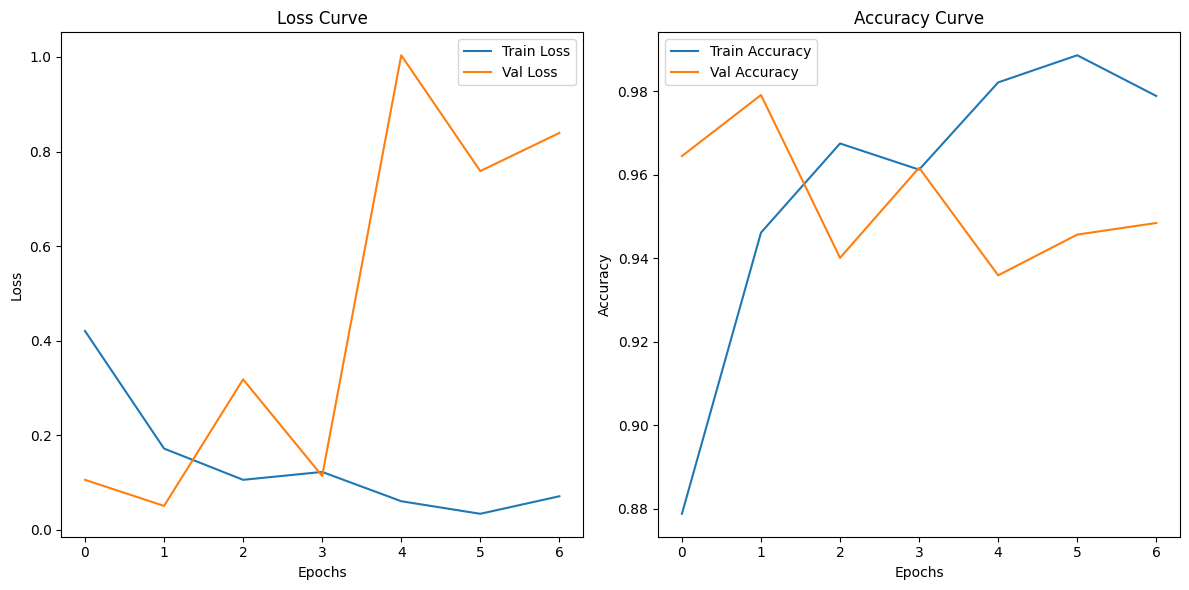

Trained Model saved to trained_model_CRC.pth
              precision    recall  f1-score   support

         ADI       0.99      0.99      0.99       267
        BACK       1.00      0.63      0.77       169
         DEB       0.96      1.00      0.98        68
         LYM       1.00      1.00      1.00       127
         MUC       0.98      1.00      0.99       207
         MUS       0.94      1.00      0.97       119
        NORM       0.71      0.95      0.81       148
         STR       0.99      0.90      0.94        84
         TUM       0.95      0.98      0.96       247

    accuracy                           0.94      1436
   macro avg       0.95      0.94      0.94      1436
weighted avg       0.95      0.94      0.94      1436



In [12]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load your dataset
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K", transform=transform)

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)

joblib.dump(trained_model, '/kaggle/working/trained_model_CRC.pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [10]:
from medmnist import PathMNIST

# Load the raw dataset to access metadata
raw_dataset = PathMNIST(split="test", download=True)

# Access the dataset information
info = raw_dataset.info

# Number of classes
num_classes = len(info['label'])
print(f"Number of classes: {num_classes}")

# Print the label descriptions
print("Labels:", info['label'])

100%|██████████| 205615438/205615438 [00:55<00:00, 3716952.79it/s] 


Number of classes: 9
Labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


In [11]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST
trained_model_CRC= joblib.load('/kaggle/input/data-files/trained_model_CRC.pkl')
test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model_CRC, test_dataloader_PathMNIST, device, class_names)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
              precision    recall  f1-score   support

         ADI       0.71      0.96      0.81      1338
        BACK       0.27      1.00      0.43       847
         DEB       0.37      0.07      0.11       339
         LYM       0.58      0.74      0.65       634
         MUC       0.00      0.00      0.00      1035
         MUS       0.67      0.18      0.29       592
        NORM       0.92      0.43      0.58       741
         STR       0.24      0.23      0.23       421
         TUM       0.72      0.27      0.40      1233

    accuracy                           0.48      7180
   macro avg       0.50      0.43      0.39      7180
weighted avg       0.52      0.48      0.43      7180



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 0.4286 Acc: 0.8793
--------------------
val Loss: 0.1051 Acc: 0.9714
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.1591 Acc: 0.9496
--------------------
val Loss: 0.4456 Acc: 0.9387
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.1302 Acc: 0.9605
--------------------
val Loss: 0.0455 Acc: 0.9875
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0983 Acc: 0.9684
--------------------
val Loss: 0.0457 Acc: 0.9882
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0861 Acc: 0.9742
--------------------
val Loss: 0.1564 Acc: 0.9652
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0485 Acc: 0.9842
--------------------
val Loss: 0.1617 Acc: 0.9589
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0409 Acc: 

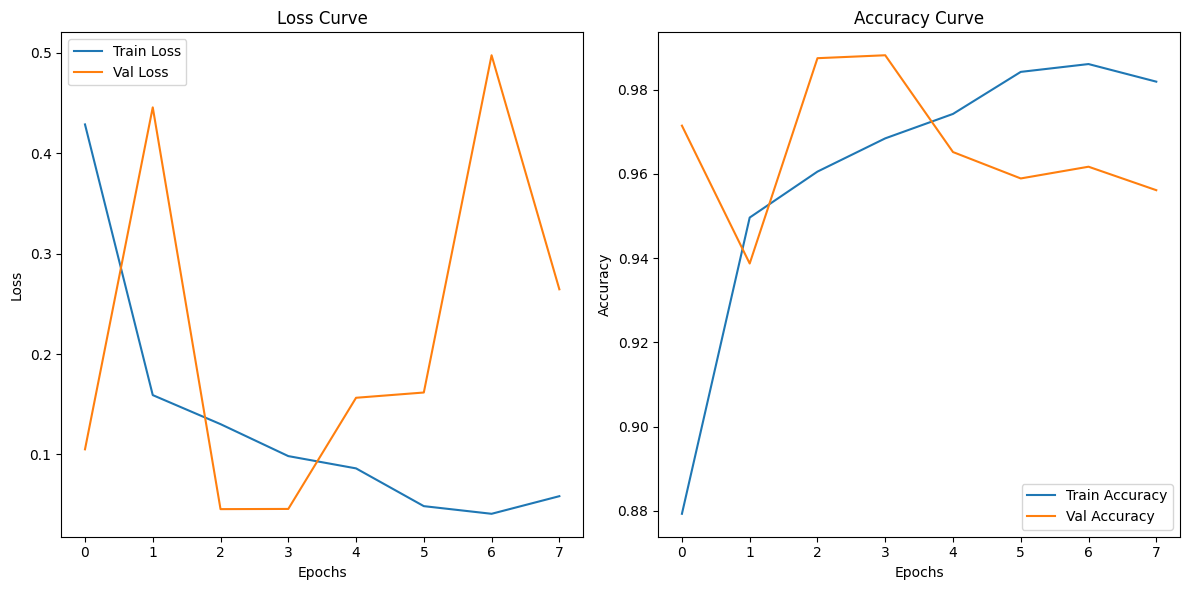

Trained Model saved to trained_model_CRC(transform).pth
              precision    recall  f1-score   support

         ADI       0.89      0.98      0.93       268
        BACK       1.00      0.78      0.88       169
         DEB       0.99      1.00      0.99        68
         LYM       0.98      1.00      0.99       127
         MUC       1.00      1.00      1.00       207
         MUS       0.97      1.00      0.98       118
        NORM       0.97      0.95      0.96       148
         STR       0.99      0.99      0.99        84
         TUM       0.98      0.99      0.98       247

    accuracy                           0.96      1436
   macro avg       0.97      0.97      0.97      1436
weighted avg       0.97      0.96      0.96      1436



In [19]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################
############################ TRAIN TRANSFORM DIFFERENT FROM VAL_TEST TRANSFORM##########################

# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets


# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)

joblib.dump(trained_model, '/kaggle/working/trained_model_CRC(transform).pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC(transform).pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [20]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################
############################ TRAIN TRANSFORM DIFFERENT FROM VAL_TEST TRANSFORM##########################

# Trained on CRC and testing on PathMNIST
trained_model_CRC_transform= joblib.load('/kaggle/input/model-weights/trained_model_CRC(transform).pkl')
test_dataset = PathMNIST(split="test", transform=val_test_transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model_CRC_transform, test_dataloader_PathMNIST, device, class_names)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
              precision    recall  f1-score   support

         ADI       0.77      0.88      0.82      1338
        BACK       0.00      0.00      0.00       847
         DEB       1.00      0.24      0.39       339
         LYM       0.00      0.00      0.00       634
         MUC       0.08      0.13      0.10      1035
         MUS       0.34      0.26      0.29       592
        NORM       0.56      0.84      0.67       741
         STR       0.12      0.09      0.10       421
         TUM       0.57      0.10      0.17      1233

    accuracy                           0.33      7180
   macro avg       0.38      0.28      0.28      7180
weighted avg       0.39      0.33      0.31      7180



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Train model on PathMNIST Dataset**

In [20]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Apply the transformations to the train and validation datasets
# Set download=True to download the dataset
train_dataset = PathMNIST(split="train", transform=transform, download=True)
val_dataset = PathMNIST(split="val", transform=transform, download=True)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Print the dataset sizes to verify
print("Training dataset size:", dataset_sizes['train'])
print("Validation dataset size:", dataset_sizes['val'])

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training dataset size: 89996
Validation dataset size: 10004


In [21]:

# Load the raw dataset to access metadata
raw_dataset = PathMNIST(split="train", download=True)

# Access the dataset information
info = raw_dataset.info

# Number of classes
num_classes = len(info['label'])
print(f"Number of classes: {num_classes}")

# Print the label descriptions
print("Labels:", info['label'])


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Number of classes: 9
Labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


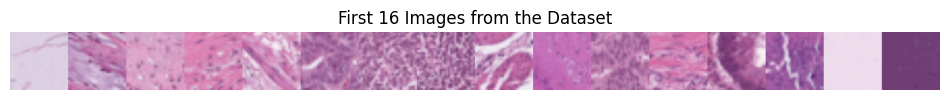

In [25]:

# Function to display a batch of images with their labels
def visualize_batch(dataset, num_images=16):
    # Get a batch of data
    images, labels = zip(*[dataset[i] for i in range(num_images)])
    images = torch.stack(images)  # Stack images into a batch
    
    # Create a grid to display the images
    grid_img = torch.cat([img for img in images], dim=2)  # Concatenate images horizontally
    grid_img = grid_img.permute(1, 2, 0)  # Rearrange dimensions for plotting (HWC)
    
    # Denormalize the images for visualization
    grid_img = grid_img * torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    grid_img += torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    grid_img = torch.clamp(grid_img, 0, 1)
    
    # Plot the images
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_img.numpy())
    plt.axis('off')
    plt.title(f'First {num_images} Images from the Dataset')
    plt.show()

# Visualize the training dataset
visualize_batch(train_dataset, num_images=16)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------------------------------------
train Loss: 0.2668 Acc: 0.9118
--------------------
val Loss: 0.1357 Acc: 0.9594
--------------------
Epoch 2/10
----------------------------------------
train Loss: 0.1386 Acc: 0.9545
--------------------
val Loss: 0.0898 Acc: 0.9698
--------------------
Epoch 3/10
----------------------------------------
train Loss: 0.1033 Acc: 0.9656
--------------------
val Loss: 0.1741 Acc: 0.9692
--------------------
Epoch 4/10
----------------------------------------
train Loss: 0.0861 Acc: 0.9715
--------------------
val Loss: 3.1999 Acc: 0.9434
--------------------
Epoch 5/10
----------------------------------------
train Loss: 0.0743 Acc: 0.9754
--------------------
val Loss: 0.5547 Acc: 0.9758
--------------------
Epoch 6/10
----------------------------------------
train Loss: 0.0647 Acc: 0.9790
--------------------
val Loss: 0.5054 Acc: 0.9532
--------------------
Epoch 7/10
----------------------------------------
train Loss: 0.0572 Acc: 

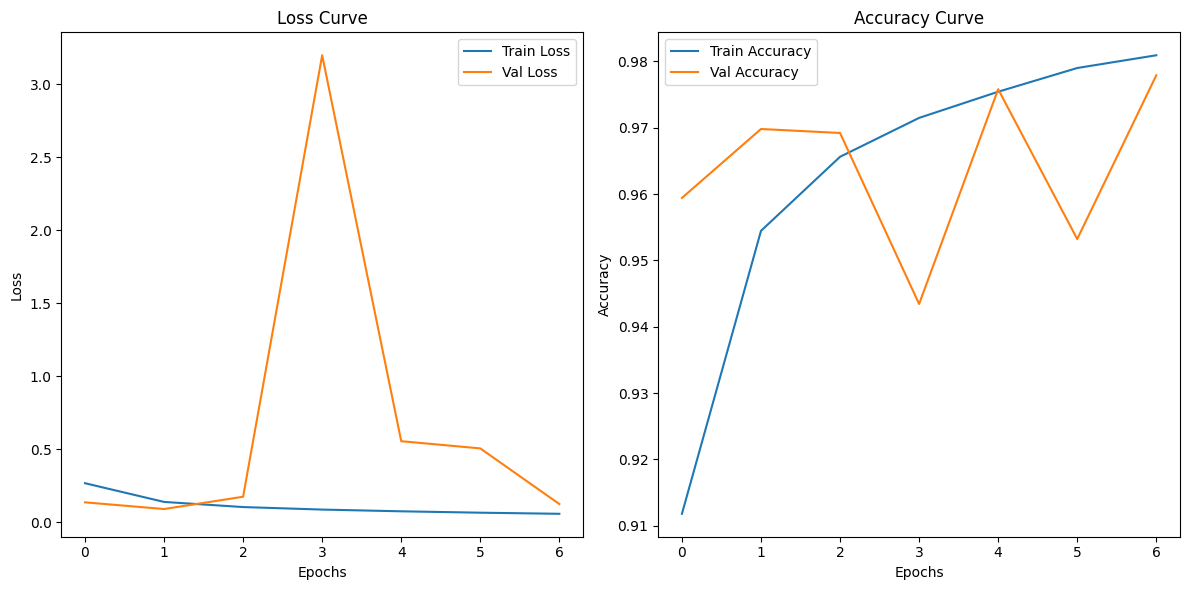

              precision    recall  f1-score   support

         ADI       0.94      0.99      0.96      1338
        BACK       0.77      1.00      0.87       847
         DEB       0.72      0.36      0.48       339
         LYM       0.90      1.00      0.95       634
         MUC       1.00      0.86      0.92      1035
         MUS       0.67      0.88      0.76       592
        NORM       0.97      0.94      0.96       741
         STR       0.97      0.40      0.57       421
         TUM       0.94      0.95      0.95      1233

    accuracy                           0.89      7180
   macro avg       0.88      0.82      0.82      7180
weighted avg       0.90      0.89      0.88      7180



In [12]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=10)
joblib.dump(trained_model, '/kaggle/working/trained_model_PathMNIST.pkl')

# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

In [11]:
trained_model_PathMNIST= joblib.load('/kaggle/input/model-weights/trained_model_PathMNIST.pkl')
# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model_PathMNIST, test_dataloader_PathMNIST, device, class_names)

              precision    recall  f1-score   support

         ADI       0.97      0.69      0.81      1338
        BACK       0.89      1.00      0.94       847
         DEB       0.84      0.93      0.89       339
         LYM       0.92      1.00      0.96       634
         MUC       1.00      0.89      0.94      1035
         MUS       0.47      0.89      0.62       592
        NORM       0.95      0.97      0.96       741
         STR       0.94      0.39      0.56       421
         TUM       0.93      0.94      0.94      1233

    accuracy                           0.86      7180
   macro avg       0.88      0.86      0.84      7180
weighted avg       0.90      0.86      0.87      7180



In [13]:
# Save the model's state dictionary
model_save_path = "trained_model_PathMNIST.pth"
torch.save(trained_model_PathMNIST.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to trained_model_PathMNIST.pth


In [14]:


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
crc_dataloaders  = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
crc_dataset_sizes  = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_23/732486415.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models fo

Epoch 1/50
----------------------------------------
train Loss: 0.6511 Acc: 0.8461
--------------------
val Loss: 1.1116 Acc: 0.7869
--------------------
Epoch 2/50
----------------------------------------
train Loss: 0.5432 Acc: 0.8644
--------------------
val Loss: 0.7682 Acc: 0.8148
--------------------
Epoch 3/50
----------------------------------------
train Loss: 0.4520 Acc: 0.8777
--------------------
val Loss: 0.9196 Acc: 0.8029
--------------------
Epoch 4/50
----------------------------------------
train Loss: 0.4007 Acc: 0.8895
--------------------
val Loss: 0.5508 Acc: 0.8517
--------------------
Epoch 5/50
----------------------------------------
train Loss: 0.3648 Acc: 0.8944
--------------------
val Loss: 0.6806 Acc: 0.8350
--------------------
Epoch 6/50
----------------------------------------
train Loss: 0.3509 Acc: 0.8886
--------------------
val Loss: 0.7376 Acc: 0.8238
--------------------
Epoch 7/50
----------------------------------------
train Loss: 0.3095 Acc: 

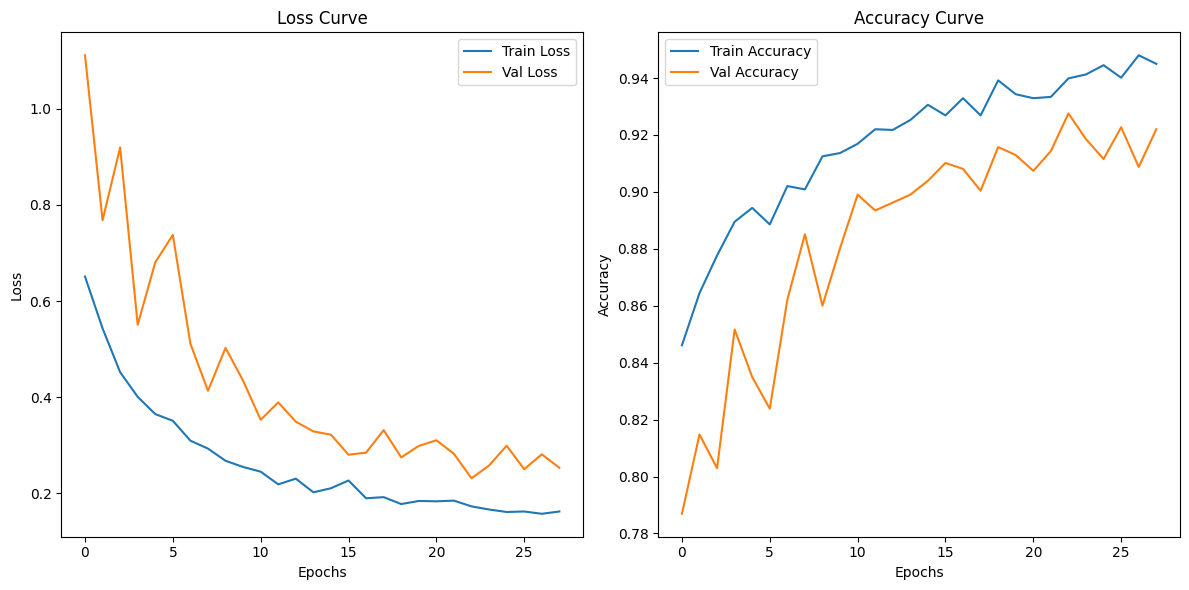

Finetuned Model saved to finetuned_model_PathMNIST.pth


In [31]:
# Load the pretrained model
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes
pretrained_model_path = "/kaggle/working/trained_model_PathMNIST.pth"  # Replace with your saved PathMNIST model path
model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights

# Step 3: Adjust the model for finetuning
# Freeze earlier layers (optional for transfer learning)
for param in model.efficientnet_b0.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Ensure classifier is trainable
for param in model.efficientnet_b0.classifier.parameters():
    param.requires_grad = True

# Finetune the model on CRC-VAL-HE-7K
finetuned_model = train_model(
    model,
    dataloaders=crc_dataloaders,
    dataset_sizes=crc_dataset_sizes,
    device=device,
    num_epochs=50,
    learning_rate=1e-4,  # Use a lower learning rate for finetuning
    patience=5  # Early stopping patience
)

joblib.dump(finetuned_model, '/kaggle/working/finetuned_model_PathMNIST.pkl')
# Save the model's state dictionary
model_save_path = "finetuned_model_PathMNIST.pth"
torch.save(finetuned_model.state_dict(), model_save_path)
print(f"Finetuned Model saved to {model_save_path}")


In [33]:
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(finetuned_model, test_dataloader, device, class_names)

              precision    recall  f1-score   support

         ADI       1.00      0.97      0.98       267
        BACK       0.99      0.99      0.99       170
         DEB       0.70      0.96      0.81        68
         LYM       0.95      0.97      0.96       127
         MUC       0.99      0.94      0.97       207
         MUS       0.81      0.88      0.84       118
        NORM       0.92      0.97      0.94       148
         STR       0.86      0.51      0.64        84
         TUM       0.91      0.92      0.92       247

    accuracy                           0.93      1436
   macro avg       0.90      0.90      0.89      1436
weighted avg       0.93      0.93      0.92      1436



# SE Block Model with B0 Encoder (Focal Loss)

In [12]:
import torch
import torch.nn as nn
from torchvision import models

# CBAM Block
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        # Channel Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        att_c = self.channel_att(x)
        x = x * att_c
        # Spatial Attention
        att_s = self.spatial_att(torch.cat([x.mean(dim=1, keepdim=True), x.max(dim=1, keepdim=True).values], dim=1))
        x = x * att_s
        return x


# Modified EfficientNet-B0 with CBAM for Classification
class ModifiedEfficientNetB0_CBAM(nn.Module):
    def __init__(self, num_classes=9):
        super(ModifiedEfficientNetB0_CBAM, self).__init__()
        self.efficientnet_b0 = models.efficientnet_b0(pretrained=True)

        # Replace SE Blocks with CBAM
        self.cbam1 = CBAMBlock(channels=24)
        self.cbam2 = CBAMBlock(channels=80)
        self.cbam3 = CBAMBlock(channels=320)
        self.cbam4 = CBAMBlock(channels=1280)

        # Modify the final layer for classification
        self.efficientnet_b0.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.efficientnet_b0.features[0:3](x)  # Output channels: 24
        x = self.cbam1(x)

        x = self.efficientnet_b0.features[3:5](x)  # Output channels: 80
        x = self.cbam2(x)

        x = self.efficientnet_b0.features[5:8](x)  # Output channels: 320
        x = self.cbam3(x)

        x = self.efficientnet_b0.features[8:](x)  # Output channels: 1280
        x = self.cbam4(x)

        x = self.efficientnet_b0.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.efficientnet_b0.classifier(x)
        return x


In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, dataloaders, dataset_sizes, device, num_epochs=10, learning_rate=0.001, patience=5):
    # Define the criterion (Focal Loss) and optimizer
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    # Track losses and accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = np.inf
    no_improvement_epochs = 0
    best_model_weights = model.state_dict()  # Save the best model weights
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 40)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Conditionally squeeze labels only if they are 2D
                if labels.dim() > 1:
                    labels = labels.squeeze()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    no_improvement_epochs = 0
                    best_model_weights = model.state_dict()
                else:
                    no_improvement_epochs += 1

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print('-' * 20)

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_weights)

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------------------------------------
train Loss: 0.1259 Acc: 0.8707
--------------------
val Loss: 0.0037 Acc: 0.9638
--------------------
Epoch 2/10
----------------------------------------
train Loss: 0.0160 Acc: 0.9399
--------------------
val Loss: 0.0151 Acc: 0.9373
--------------------
Epoch 3/10
----------------------------------------
train Loss: 0.0098 Acc: 0.9582
--------------------
val Loss: 0.0016 Acc: 0.9812
--------------------
Epoch 4/10
----------------------------------------
train Loss: 0.0211 Acc: 0.9390
--------------------
val Loss: 0.2812 Acc: 0.9171
--------------------
Epoch 5/10
----------------------------------------
train Loss: 0.0388 Acc: 0.9148
--------------------
val Loss: 0.0093 Acc: 0.9338
--------------------
Epoch 6/10
----------------------------------------
train Loss: 0.0073 Acc: 0.9580
--------------------
val Loss: 0.1197 Acc: 0.9721
--------------------
Epoch 7/10
----------------------------------------
train Loss: 0.0114 Acc: 

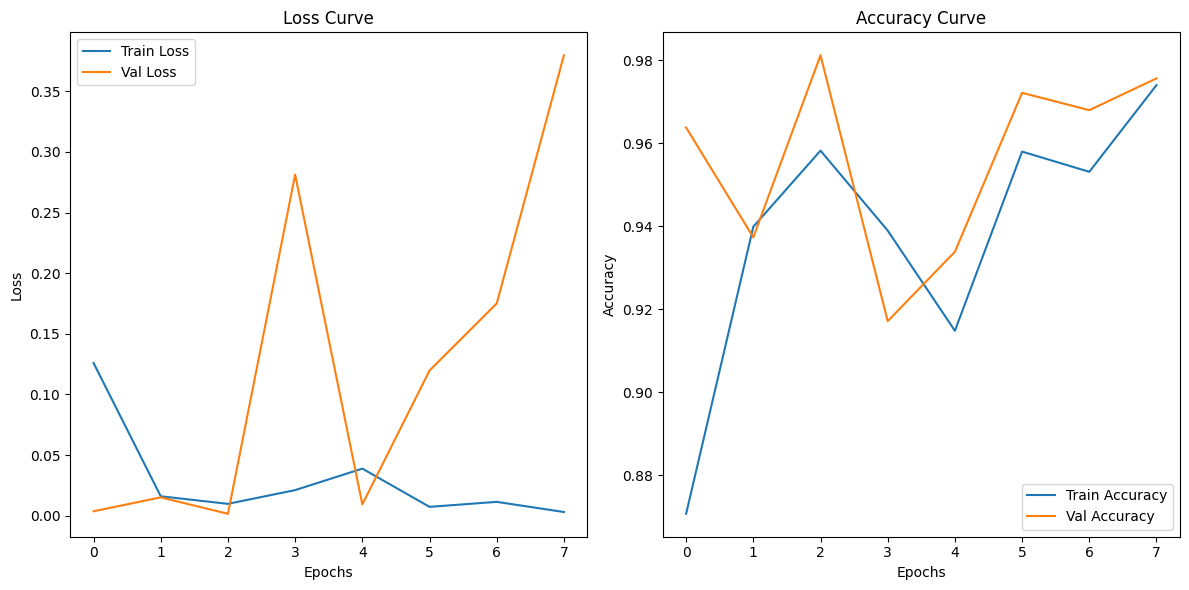

Trained Model saved to trained_model_CRC.pth
              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00       268
        BACK       1.00      1.00      1.00       169
         DEB       1.00      0.99      0.99        68
         LYM       0.98      1.00      0.99       127
         MUC       1.00      1.00      1.00       207
         MUS       0.94      0.75      0.84       118
        NORM       0.98      0.98      0.98       148
         STR       0.95      0.92      0.93        84
         TUM       0.90      1.00      0.95       247

    accuracy                           0.97      1436
   macro avg       0.97      0.96      0.96      1436
weighted avg       0.97      0.97      0.97      1436



In [15]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load your dataset
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K", transform=transform)

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=10)



# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [16]:
joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_Focal.pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_Focal.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

Trained Model saved to trained_model_CRC_CBAM.pth


In [17]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

100%|██████████| 205615438/205615438 [00:16<00:00, 12720690.55it/s]


              precision    recall  f1-score   support

         ADI       0.79      0.98      0.87      1338
        BACK       0.36      1.00      0.53       847
         DEB       0.94      0.49      0.64       339
         LYM       0.91      0.59      0.71       634
         MUC       0.80      0.14      0.24      1035
         MUS       0.56      0.04      0.07       592
        NORM       0.80      0.38      0.52       741
         STR       0.70      0.04      0.07       421
         TUM       0.53      0.86      0.66      1233

    accuracy                           0.59      7180
   macro avg       0.71      0.50      0.48      7180
weighted avg       0.69      0.59      0.53      7180



Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 0.1026 Acc: 0.8763
--------------------
val Loss: 0.0081 Acc: 0.9589
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.0306 Acc: 0.9201
--------------------
val Loss: 0.0015 Acc: 0.9812
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.0105 Acc: 0.9564
--------------------
val Loss: 0.0019 Acc: 0.9854
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0021 Acc: 0.9768
--------------------
val Loss: 0.0006 Acc: 0.9923
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0063 Acc: 0.9638
--------------------
val Loss: 0.0005 Acc: 0.9854
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0047 Acc: 0.9677
--------------------
val Loss: 0.0545 Acc: 0.9067
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0737 Acc: 

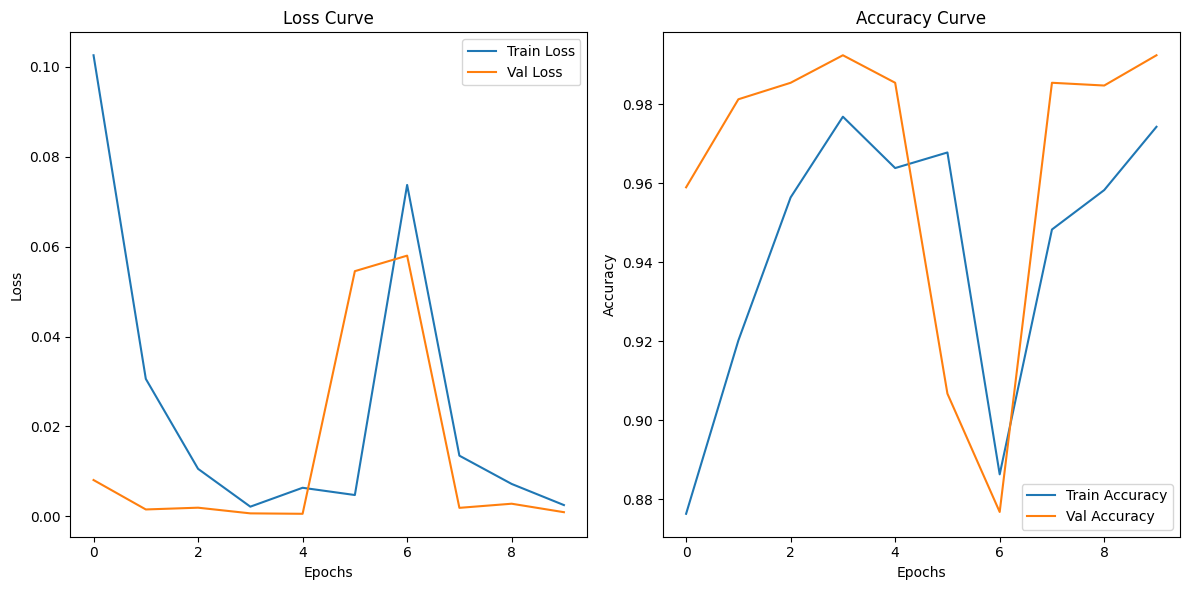

Trained Model saved to trained_model_CRC_CBAM(transform).pth
              precision    recall  f1-score   support

         ADI       1.00      0.99      1.00       268
        BACK       1.00      1.00      1.00       169
         DEB       1.00      0.99      0.99        68
         LYM       0.97      1.00      0.98       127
         MUC       1.00      1.00      1.00       207
         MUS       1.00      0.97      0.98       118
        NORM       0.99      0.96      0.97       148
         STR       0.95      0.99      0.97        84
         TUM       0.98      0.99      0.99       247

    accuracy                           0.99      1436
   macro avg       0.99      0.99      0.99      1436
weighted avg       0.99      0.99      0.99      1436



In [18]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################
############################ TRAIN TRANSFORM DIFFERENT FROM VAL_TEST TRANSFORM##########################

# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets


# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)

joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_Focal(transform).pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_Focal(transform).pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [19]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
              precision    recall  f1-score   support

         ADI       0.70      0.92      0.79      1338
        BACK       0.56      0.91      0.69       847
         DEB       0.82      0.03      0.05       339
         LYM       0.77      0.42      0.55       634
         MUC       0.00      0.00      0.00      1035
         MUS       0.00      0.00      0.00       592
        NORM       0.86      0.35      0.50       741
         STR       0.00      0.00      0.00       421
         TUM       0.36      0.98      0.52      1233

    accuracy                           0.52      7180
   macro avg       0.45      0.40      0.35      7180
weighted avg       0.45      0.52      0.42      7180



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Apply the transformations to the train and validation datasets
# Set download=True to download the dataset
train_dataset = PathMNIST(split="train", transform=transform, download=True)
val_dataset = PathMNIST(split="val", transform=transform, download=True)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Print the dataset sizes to verify
print("Training dataset size:", dataset_sizes['train'])
print("Validation dataset size:", dataset_sizes['val'])

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training dataset size: 89996
Validation dataset size: 10004


Epoch 1/10
----------------------------------------
train Loss: 0.0466 Acc: 0.8987
--------------------
val Loss: 0.0050 Acc: 0.9643
--------------------
Epoch 2/10
----------------------------------------
train Loss: 0.0173 Acc: 0.9319
--------------------
val Loss: 0.0060 Acc: 0.9686
--------------------
Epoch 3/10
----------------------------------------
train Loss: 0.0121 Acc: 0.9442
--------------------
val Loss: 0.0050 Acc: 0.9716
--------------------
Epoch 4/10
----------------------------------------
train Loss: 0.0088 Acc: 0.9537
--------------------
val Loss: 0.0040 Acc: 0.9698
--------------------
Epoch 5/10
----------------------------------------
train Loss: 0.0069 Acc: 0.9578
--------------------
val Loss: 0.0019 Acc: 0.9803
--------------------
Epoch 6/10
----------------------------------------
train Loss: 0.0054 Acc: 0.9621
--------------------
val Loss: 0.0237 Acc: 0.9714
--------------------
Epoch 7/10
----------------------------------------
train Loss: 0.0047 Acc: 

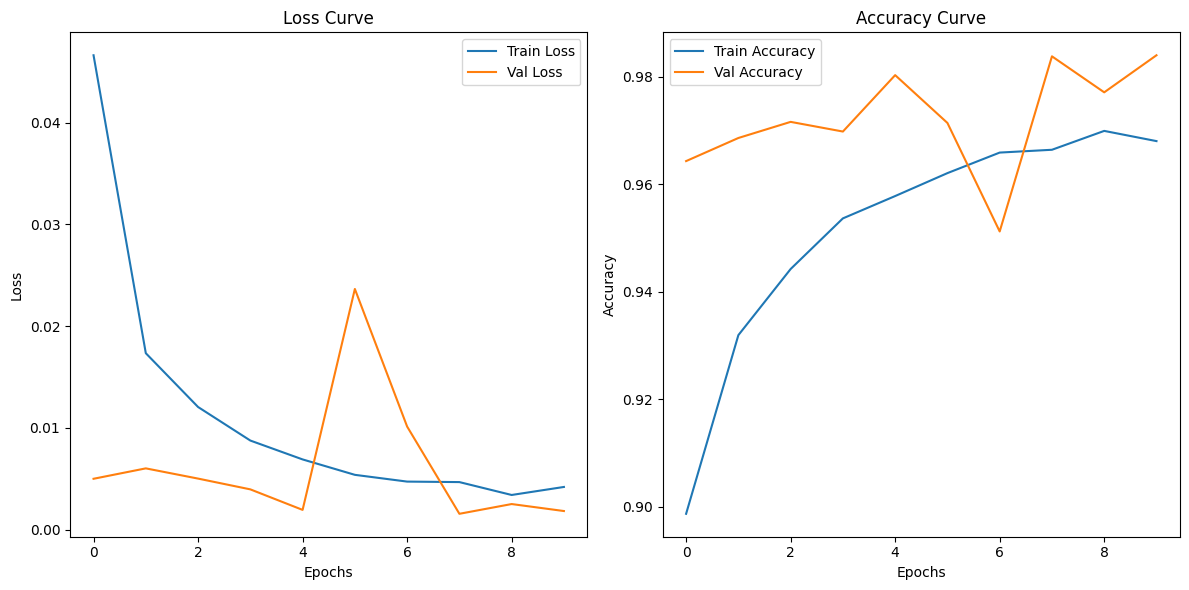

              precision    recall  f1-score   support

         ADI       0.98      0.98      0.98      1338
        BACK       0.86      1.00      0.92       847
         DEB       0.82      0.82      0.82       339
         LYM       0.97      1.00      0.99       634
         MUC       1.00      0.89      0.94      1035
         MUS       0.72      0.89      0.79       592
        NORM       0.93      0.94      0.94       741
         STR       0.90      0.41      0.56       421
         TUM       0.92      0.95      0.94      1233

    accuracy                           0.91      7180
   macro avg       0.90      0.88      0.88      7180
weighted avg       0.92      0.91      0.91      7180



In [24]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=10)
joblib.dump(trained_model, '/kaggle/working/trained_model_PathMNIST_Focal.pkl')

# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

In [26]:
trained_model_PathMNIST= joblib.load('/kaggle/working/trained_model_PathMNIST_Focal.pkl')
# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model_PathMNIST, test_dataloader_PathMNIST, device, class_names)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


              precision    recall  f1-score   support

         ADI       0.98      0.98      0.98      1338
        BACK       0.86      1.00      0.92       847
         DEB       0.82      0.82      0.82       339
         LYM       0.97      1.00      0.99       634
         MUC       1.00      0.89      0.94      1035
         MUS       0.72      0.89      0.79       592
        NORM       0.93      0.94      0.94       741
         STR       0.90      0.41      0.56       421
         TUM       0.92      0.95      0.94      1233

    accuracy                           0.91      7180
   macro avg       0.90      0.88      0.88      7180
weighted avg       0.92      0.91      0.91      7180



In [27]:
# Save the model's state dictionary
model_save_path = "trained_model_PathMNIST_Focal.pth"
torch.save(trained_model_PathMNIST.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to trained_model_PathMNIST_CBAM.pth


In [28]:


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
crc_dataloaders  = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
crc_dataset_sizes  = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


Number of classes: 9


/tmp/ipykernel_23/1810148074.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights


Epoch 1/50
----------------------------------------
train Loss: 0.0700 Acc: 0.8561
--------------------
val Loss: 0.0624 Acc: 0.8740
--------------------
Epoch 2/50
----------------------------------------
train Loss: 0.0582 Acc: 0.8661
--------------------
val Loss: 0.0687 Acc: 0.8823
--------------------
Epoch 3/50
----------------------------------------
train Loss: 0.0474 Acc: 0.8793
--------------------
val Loss: 0.0543 Acc: 0.8858
--------------------
Epoch 4/50
----------------------------------------
train Loss: 0.0373 Acc: 0.8925
--------------------
val Loss: 0.0495 Acc: 0.8942
--------------------
Epoch 5/50
----------------------------------------
train Loss: 0.0344 Acc: 0.8965
--------------------
val Loss: 0.0324 Acc: 0.8914
--------------------
Epoch 6/50
----------------------------------------
train Loss: 0.0357 Acc: 0.8911
--------------------
val Loss: 0.0412 Acc: 0.8955
--------------------
Epoch 7/50
----------------------------------------
train Loss: 0.0289 Acc: 

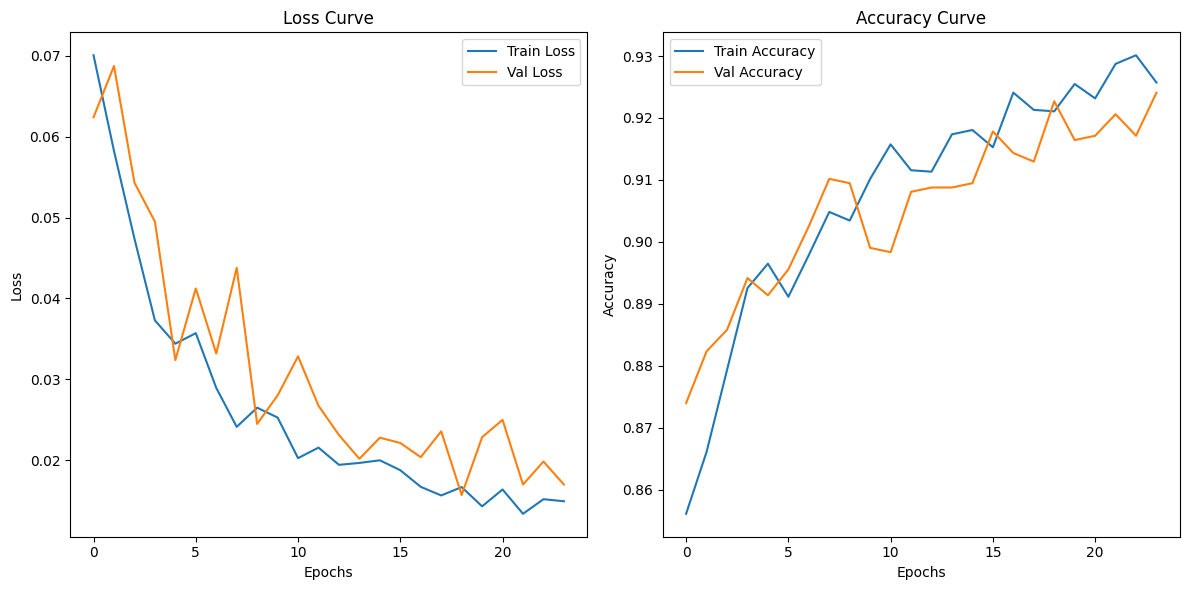

Finetuned Model saved to finetuned_model_PathMNIST_CBAM.pth


In [30]:
# Load the pretrained model
model = ModifiedEfficientNetB0(num_classes=9)  # Ensure this matches the dataset classes
pretrained_model_path = "/kaggle/working/trained_model_PathMNIST_Focal.pth"  # Replace with your saved PathMNIST model path
model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights

# Step 3: Adjust the model for finetuning
# Freeze earlier layers (optional for transfer learning)
for param in model.efficientnet_b0.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Ensure classifier is trainable
for param in model.efficientnet_b0.classifier.parameters():
    param.requires_grad = True

# Finetune the model on CRC-VAL-HE-7K
finetuned_model = train_model(
    model,
    dataloaders=crc_dataloaders,
    dataset_sizes=crc_dataset_sizes,
    device=device,
    num_epochs=50,
    learning_rate=1e-4,  # Use a lower learning rate for finetuning
    patience=5  # Early stopping patience
)

joblib.dump(finetuned_model, '/kaggle/working/finetuned_model_PathMNIST_Focal.pkl')
# Save the model's state dictionary
model_save_path = "finetuned_model_PathMNIST_Focal.pth"
torch.save(finetuned_model.state_dict(), model_save_path)
print(f"Finetuned Model saved to {model_save_path}")


In [31]:
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(finetuned_model, test_dataloader, device, class_names)

              precision    recall  f1-score   support

         ADI       1.00      0.97      0.98       267
        BACK       0.96      1.00      0.98       169
         DEB       0.85      0.78      0.82        68
         LYM       0.96      0.98      0.97       127
         MUC       0.97      0.97      0.97       207
         MUS       0.74      0.95      0.83       119
        NORM       0.93      0.92      0.92       148
         STR       0.86      0.43      0.57        84
         TUM       0.90      0.95      0.93       247

    accuracy                           0.92      1436
   macro avg       0.91      0.88      0.89      1436
weighted avg       0.92      0.92      0.92      1436



# MultiScaleFusion Model

In [12]:
import torch
import torch.nn as nn
from torchvision import models

# Multi-Scale Feature Fusion Module
class MultiScaleFusion(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFusion, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(1)  # Global Pooling
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool4 = nn.AdaptiveAvgPool2d(4)

        # Fully connected layers to learn from pooled features
        self.fc = nn.Linear(in_channels * (1 + 2 * 2 + 4 * 4), in_channels)  # Adjust for concatenated size

        self.relu = nn.ReLU()

    def forward(self, x):
        b, c, h, w = x.size()  # Batch, Channels, Height, Width

        # Apply pooling and flatten
        p1 = self.pool1(x).view(b, -1)  # Shape: (b, c * 1)
        p2 = self.pool2(x).view(b, -1)  # Shape: (b, c * 2 * 2)
        p4 = self.pool4(x).view(b, -1)  # Shape: (b, c * 4 * 4)

        # Concatenate pooled features
        fused = torch.cat([p1, p2, p4], dim=1)  # Concatenate along the channel axis

        # Learn from concatenated features
        fused = self.fc(fused)
        fused = self.relu(fused)

        return fused.view(b, c, 1, 1)  # Reshape for broadcasting



# Modified EfficientNet-B0 with Multi-Scale Feature Fusion
class ModifiedEfficientNetB0_MSFF(nn.Module):
    def __init__(self, num_classes=9):
        super(ModifiedEfficientNetB0_MSFF, self).__init__()
        self.efficientnet_b0 = models.efficientnet_b0(pretrained=True)

        # Multi-Scale Feature Fusion Modules
        self.msff1 = MultiScaleFusion(in_channels=24)
        self.msff2 = MultiScaleFusion(in_channels=80)
        self.msff3 = MultiScaleFusion(in_channels=320)
        self.msff4 = MultiScaleFusion(in_channels=1280)

        # Modify the final layer for classification
        self.efficientnet_b0.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.efficientnet_b0.features[0:3](x)  # Output channels: 24
        x = x + self.msff1(x)

        x = self.efficientnet_b0.features[3:5](x)  # Output channels: 80
        x = x + self.msff2(x)

        x = self.efficientnet_b0.features[5:8](x)  # Output channels: 320
        x = x + self.msff3(x)

        x = self.efficientnet_b0.features[8:](x)  # Output channels: 1280
        x = x + self.msff4(x)

        x = self.efficientnet_b0.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.efficientnet_b0.classifier(x)
        return x


In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, dataloaders, dataset_sizes, device, num_epochs=10, learning_rate=0.001, patience=5):
    # Define the criterion (Focal Loss) and optimizer
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    # Track losses and accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = np.inf
    no_improvement_epochs = 0
    best_model_weights = model.state_dict()  # Save the best model weights
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 40)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Conditionally squeeze labels only if they are 2D
                if labels.dim() > 1:
                    labels = labels.squeeze()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    no_improvement_epochs = 0
                    best_model_weights = model.state_dict()
                else:
                    no_improvement_epochs += 1

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print('-' * 20)

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_weights)

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 3.8915 Acc: 0.5970
--------------------
val Loss: 0.6670 Acc: 0.7013
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.3359 Acc: 0.7254
--------------------
val Loss: 0.1410 Acc: 0.8691
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.2688 Acc: 0.7762
--------------------
val Loss: 0.1085 Acc: 0.8572
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.1388 Acc: 0.8227
--------------------
val Loss: 0.1491 Acc: 0.8538
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.1125 Acc: 0.8368
--------------------
val Loss: 0.0448 Acc: 0.8705
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0777 Acc: 0.8672
--------------------
val Loss: 0.0225 Acc: 0.9227
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.1570 Acc: 

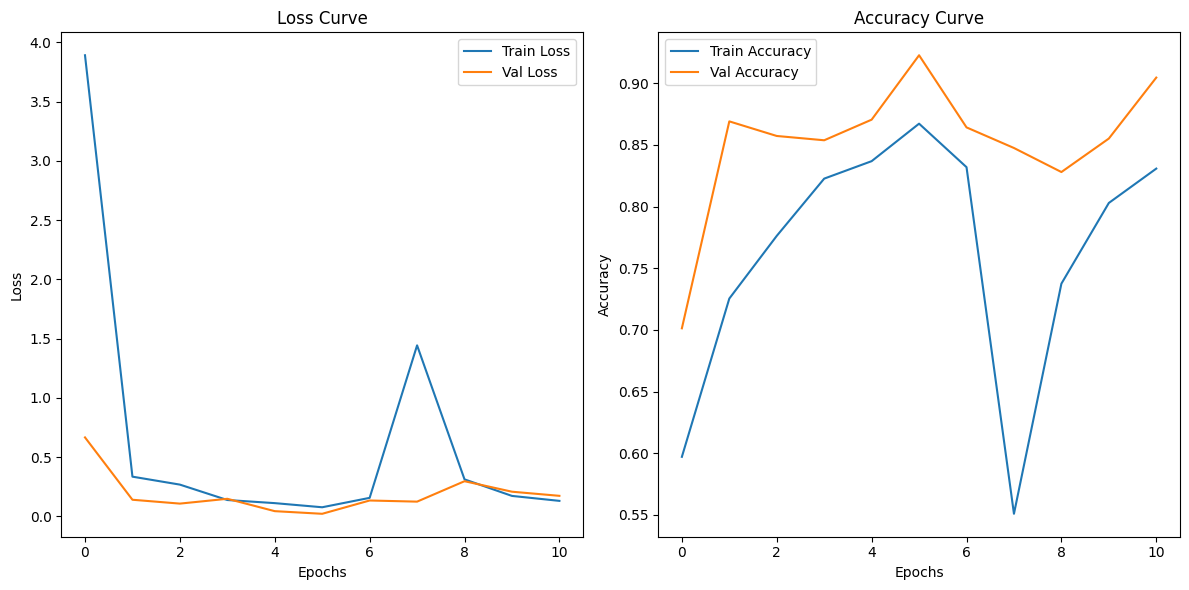

              precision    recall  f1-score   support

         ADI       0.98      1.00      0.99       268
        BACK       1.00      0.95      0.97       169
         DEB       0.83      0.99      0.90        68
         LYM       0.83      1.00      0.91       127
         MUC       0.99      0.96      0.97       207
         MUS       0.82      0.71      0.76       118
        NORM       0.96      0.74      0.83       148
         STR       0.60      0.63      0.61        84
         TUM       0.90      0.96      0.93       247

    accuracy                           0.91      1436
   macro avg       0.88      0.88      0.88      1436
weighted avg       0.91      0.91      0.91      1436



In [11]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load your dataset
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K", transform=transform)

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_MSFF(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)



# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [12]:
joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_MSFF.pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_MSFF.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

Trained Model saved to trained_model_CRC_MSFF.pth


In [13]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

100%|██████████| 205615438/205615438 [00:09<00:00, 22675473.52it/s]


              precision    recall  f1-score   support

         ADI       0.78      1.00      0.87      1338
        BACK       0.26      0.57      0.36       847
         DEB       0.06      0.01      0.02       339
         LYM       0.10      0.01      0.01       634
         MUC       0.06      0.14      0.08      1035
         MUS       0.00      0.00      0.00       592
        NORM       0.34      0.12      0.18       741
         STR       0.00      0.00      0.00       421
         TUM       0.90      0.06      0.12      1233

    accuracy                           0.30      7180
   macro avg       0.28      0.21      0.18      7180
weighted avg       0.39      0.30      0.26      7180



Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 1.2511 Acc: 0.7196
--------------------
val Loss: 0.0354 Acc: 0.8962
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.0809 Acc: 0.8765
--------------------
val Loss: 0.0033 Acc: 0.9645
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.0211 Acc: 0.9327
--------------------
val Loss: 0.0065 Acc: 0.9547
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0165 Acc: 0.9383
--------------------
val Loss: 0.0012 Acc: 0.9777
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.9952 Acc: 0.6474
--------------------
val Loss: 0.2440 Acc: 0.7618
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.1910 Acc: 0.7883
--------------------
val Loss: 0.0197 Acc: 0.9248
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0569 Acc: 

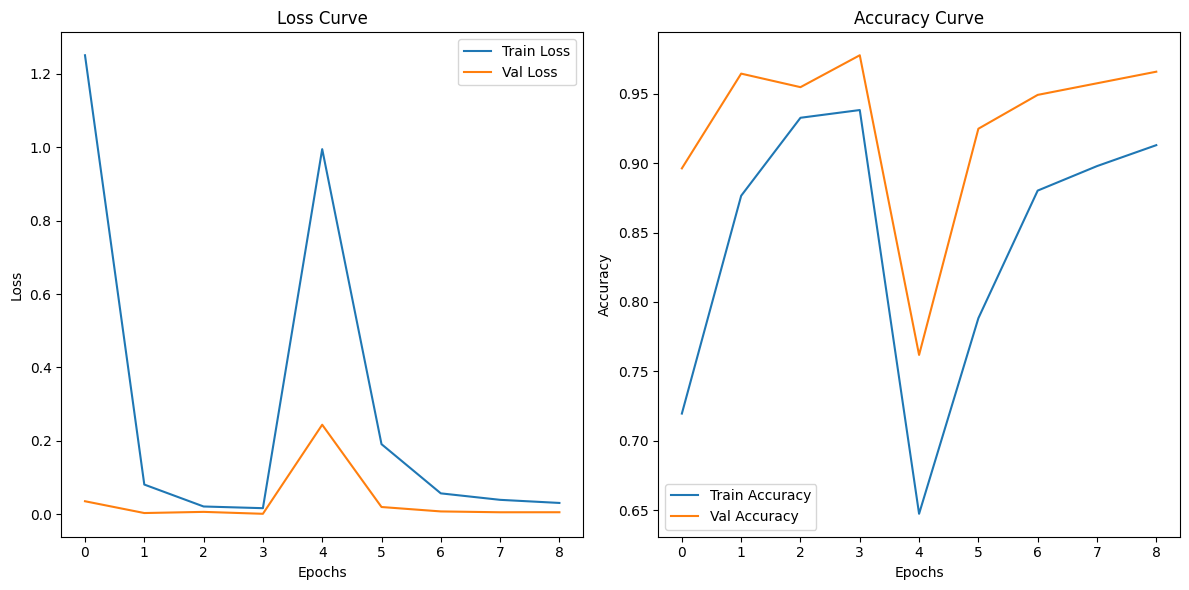

Trained Model saved to trained_model_CRC_MSFF(transform).pth
              precision    recall  f1-score   support

         ADI       0.99      0.99      0.99       267
        BACK       1.00      0.98      0.99       169
         DEB       0.86      0.99      0.92        68
         LYM       0.98      1.00      0.99       127
         MUC       0.98      0.99      0.98       207
         MUS       0.95      0.99      0.97       119
        NORM       0.98      0.92      0.95       148
         STR       0.97      0.76      0.85        84
         TUM       0.96      0.99      0.97       247

    accuracy                           0.97      1436
   macro avg       0.96      0.96      0.96      1436
weighted avg       0.97      0.97      0.97      1436



In [14]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################
############################ TRAIN TRANSFORM DIFFERENT FROM VAL_TEST TRANSFORM##########################

# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets


# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_MSFF(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)

joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_MSFF(transform).pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_MSFF(transform).pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [15]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
              precision    recall  f1-score   support

         ADI       0.52      0.78      0.62      1338
        BACK       0.00      0.01      0.00       847
         DEB       1.00      0.00      0.01       339
         LYM       0.00      0.00      0.00       634
         MUC       0.16      0.02      0.04      1035
         MUS       0.09      0.00      0.01       592
        NORM       0.36      0.32      0.34       741
         STR       0.04      0.00      0.00       421
         TUM       0.88      0.03      0.07      1233

    accuracy                           0.19      7180
   macro avg       0.34      0.13      0.12      7180
weighted avg       0.36      0.19      0.17      7180



In [18]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Apply the transformations to the train and validation datasets
# Set download=True to download the dataset
train_dataset = PathMNIST(split="train", transform=transform, download=True)
val_dataset = PathMNIST(split="val", transform=transform, download=True)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Print the dataset sizes to verify
print("Training dataset size:", dataset_sizes['train'])
print("Validation dataset size:", dataset_sizes['val'])

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training dataset size: 89996
Validation dataset size: 10004


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------------------------------------
train Loss: 0.1107 Acc: 0.8700
--------------------
val Loss: 0.0759 Acc: 0.9495
--------------------
Epoch 2/10
----------------------------------------
train Loss: 0.0280 Acc: 0.9166
--------------------
val Loss: 0.0043 Acc: 0.9669
--------------------
Epoch 3/10
----------------------------------------
train Loss: 0.0177 Acc: 0.9351
--------------------
val Loss: 0.0034 Acc: 0.9718
--------------------
Epoch 4/10
----------------------------------------
train Loss: 0.0127 Acc: 0.9465
--------------------
val Loss: 0.0015 Acc: 0.9803
--------------------
Epoch 5/10
----------------------------------------
train Loss: 0.0083 Acc: 0.9538
--------------------
val Loss: 0.0069 Acc: 0.9610
--------------------
Epoch 6/10
----------------------------------------
train Loss: 0.0064 Acc: 0.9594
--------------------
val Loss: 0.0753 Acc: 0.9859
--------------------
Epoch 7/10
----------------------------------------
train Loss: 0.0055 Acc: 

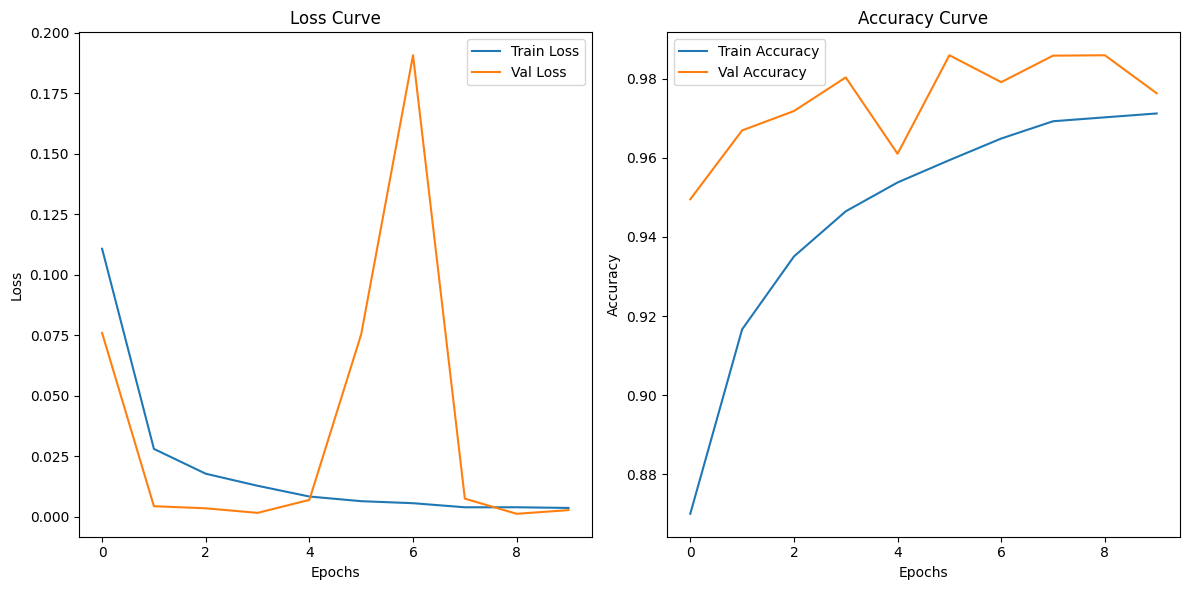

              precision    recall  f1-score   support

         ADI       0.96      0.87      0.92      1338
        BACK       0.87      1.00      0.93       847
         DEB       0.85      0.72      0.78       339
         LYM       0.89      1.00      0.94       634
         MUC       0.99      0.87      0.93      1035
         MUS       0.59      0.89      0.71       592
        NORM       0.95      0.96      0.96       741
         STR       0.95      0.43      0.59       421
         TUM       0.94      0.95      0.94      1233

    accuracy                           0.89      7180
   macro avg       0.89      0.86      0.86      7180
weighted avg       0.91      0.89      0.89      7180



In [19]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_MSFF(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=10)
joblib.dump(trained_model, '/kaggle/working/trained_model_PathMNIST_MSFF.pkl')

# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

In [16]:
# Save the model's state dictionary
trained_model=joblib.load("/kaggle/input/model-weights-of-msff/trained_model_PathMNIST_MSFF.pkl")
model_save_path = "trained_model_PathMNIST_MSFF.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Model saved to trained_model_PathMNIST_MSFF.pth


In [15]:


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
crc_dataloaders  = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
crc_dataset_sizes  = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


Number of classes: 9


/tmp/ipykernel_23/1488747038.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights


Epoch 1/50
----------------------------------------
train Loss: 0.1627 Acc: 0.8268
--------------------
val Loss: 0.2134 Acc: 0.7974
--------------------
Epoch 2/50
----------------------------------------
train Loss: 0.1075 Acc: 0.8468
--------------------
val Loss: 0.2397 Acc: 0.7911
--------------------
Epoch 3/50
----------------------------------------
train Loss: 0.0772 Acc: 0.8598
--------------------
val Loss: 0.1461 Acc: 0.8217
--------------------
Epoch 4/50
----------------------------------------
train Loss: 0.0798 Acc: 0.8695
--------------------
val Loss: 0.1357 Acc: 0.8343
--------------------
Epoch 5/50
----------------------------------------
train Loss: 0.0718 Acc: 0.8712
--------------------
val Loss: 0.1024 Acc: 0.8517
--------------------
Epoch 6/50
----------------------------------------
train Loss: 0.0597 Acc: 0.8737
--------------------
val Loss: 0.1311 Acc: 0.8405
--------------------
Epoch 7/50
----------------------------------------
train Loss: 0.0580 Acc: 

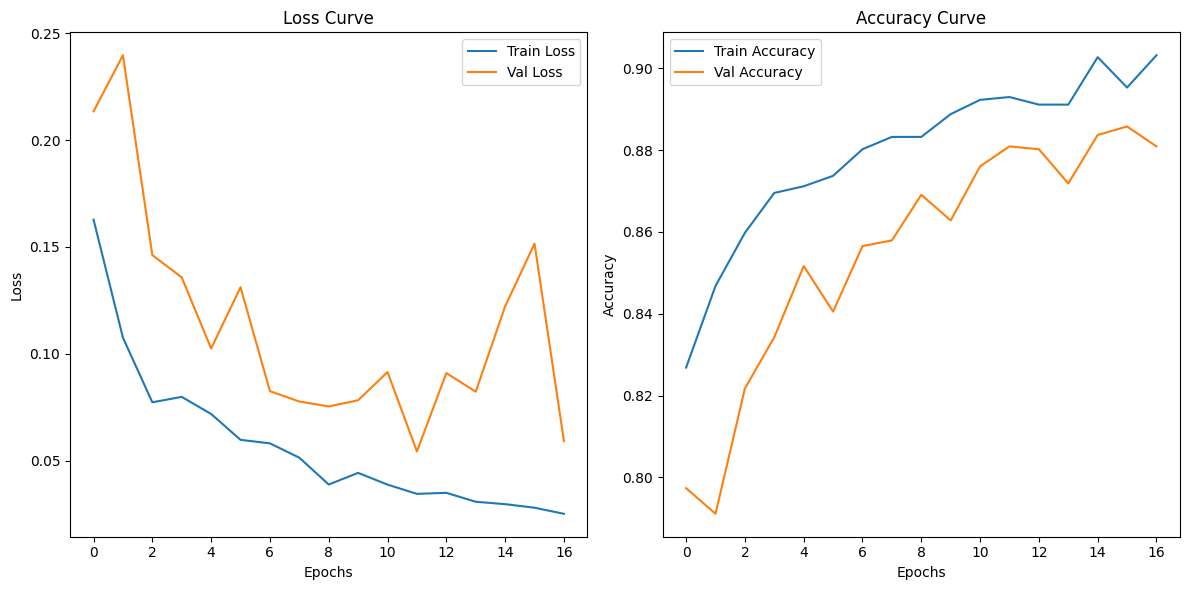

Finetuned Model saved to finetuned_model_PathMNIST_MSFF.pth


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the pretrained model
model = ModifiedEfficientNetB0_MSFF(num_classes=9)  # Ensure this matches the dataset classes
pretrained_model_path = "/kaggle/working/trained_model_PathMNIST_MSFF.pth"  # Replace with your saved PathMNIST model path
model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights

# Step 3: Adjust the model for finetuning
# Freeze earlier layers (optional for transfer learning)
for param in model.efficientnet_b0.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Ensure classifier is trainable
for param in model.efficientnet_b0.classifier.parameters():
    param.requires_grad = True

# Finetune the model on CRC-VAL-HE-7K
finetuned_model = train_model(
    model,
    dataloaders=crc_dataloaders,
    dataset_sizes=crc_dataset_sizes,
    device=device,
    num_epochs=50,
    learning_rate=1e-4,  # Use a lower learning rate for finetuning
    patience=5  # Early stopping patience
)

joblib.dump(finetuned_model, '/kaggle/working/finetuned_model_PathMNIST_MSFF.pkl')
# Save the model's state dictionary
model_save_path = "finetuned_model_PathMNIST_MSFF.pth"
torch.save(finetuned_model.state_dict(), model_save_path)
print(f"Finetuned Model saved to {model_save_path}")


In [19]:
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(finetuned_model, test_dataloader, device, class_names)

              precision    recall  f1-score   support

         ADI       1.00      0.96      0.98       267
        BACK       0.97      1.00      0.98       169
         DEB       0.77      0.87      0.81        68
         LYM       0.80      0.99      0.89       127
         MUC       0.99      0.89      0.94       207
         MUS       0.63      0.89      0.74       119
        NORM       0.94      0.93      0.94       148
         STR       0.84      0.37      0.51        84
         TUM       0.94      0.89      0.92       247

    accuracy                           0.90      1436
   macro avg       0.88      0.87      0.86      1436
weighted avg       0.91      0.90      0.89      1436



# Don't Know

In [13]:
# Copyright 2024 by Andrey Ignatov. All Rights Reserved.

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, relu=False):
        super(UpsampleConvLayer, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.upconv(x)
        out = self.relu(out)
        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class ResidualBlock(nn.Module):
    """Simple Residual Block to enhance feature learning."""
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block for Channel Attention."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = x.view(batch, channels, -1).mean(dim=2)  # Global Average Pooling
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y


class DeepCMorphSegmentationModule(nn.Module):
    def __init__(self, use_skips=False, num_classes=7, use_attention=False, dropout_rate=0.0):
        super(DeepCMorphSegmentationModule, self).__init__()

        net = models.efficientnet_b7(weights=None)

        self.return_nodes = {
            "features.2.0.block.0": "f1",
            "features.3.0.block.0": "f2",
            "features.4.0.block.0": "f3",
            "features.6.0.block.0": "f4",
        }

        self.encoder = create_feature_extractor(net, return_nodes=self.return_nodes)

        for p in self.encoder.parameters():
            p.requires_grad = True

        self.use_skips = use_skips
        self.use_attention = use_attention

        self.upsample_1 = UpsampleConvLayer(1344, 512, 2)
        self.upsample_2 = UpsampleConvLayer(512, 256, 2)
        self.upsample_3 = UpsampleConvLayer(256, 128, 2)
        self.upsample_4 = UpsampleConvLayer(128, 64, 2)

        self.conv_1 = DoubleConv(992, 512)
        self.conv_2 = DoubleConv(544, 256)
        self.conv_3 = DoubleConv(320, 128)
        self.conv_4 = DoubleConv(64, 64)

        # Residual block and optional SE attention
        self.residual_block = ResidualBlock(64, 64)
        self.attention = SEBlock(64) if self.use_attention else nn.Identity()

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        self.conv_segmentation = nn.Conv2d(64, 1, 3, 1, padding="same")
        self.conv_classification = nn.Conv2d(64, num_classes, 3, 1, padding="same")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        features = self.encoder(x)

        net = self.conv_1(torch.cat((self.upsample_1(features["f4"]), features["f3"]), dim=1))
        net = self.conv_2(torch.cat((self.upsample_2(net), features["f2"]), dim=1))
        net = self.conv_3(torch.cat((self.upsample_3(net), features["f1"]), dim=1))
        net = self.conv_4(self.upsample_4(net))

        # Residual and attention block
        net = self.residual_block(net)
        net = self.attention(net)

        net = self.dropout(net)

        predictions_segmentation = self.sigmoid(self.conv_segmentation(net))
        predictions_classification = self.sigmoid(self.conv_classification(net))

        return predictions_segmentation, predictions_classification


class DeepCMorph(nn.Module):
    def __init__(self, num_classes=41, dropout_rate=0.0, freeze_classification_module=False, freeze_segmentation_module=True):
        super(DeepCMorph, self).__init__()

        self.num_classes = num_classes
        self.use_dropout = True if dropout_rate > 0 else False
        self.dropout = nn.Dropout(dropout_rate)

        # Defining nuclei segmentation and classification module
        self.model_preprocessing = DeepCMorphSegmentationModule(use_attention=True, dropout_rate=dropout_rate)

        # Freezing the weights of the segmentation module
        for p in self.model_preprocessing.parameters():
            p.requires_grad = False if freeze_segmentation_module else True

        # Defining the DeepCMorph classification module
        EfficientNetB7_backbone = models.efficientnet_b7(weights=None)
        self.return_nodes = {"flatten": "features"}

        self.encoder = create_feature_extractor(EfficientNetB7_backbone, return_nodes=self.return_nodes)

        # Adjust input channels
        self.encoder.features._modules['0'] = nn.Conv2d(11, 64, 3, stride=2, padding=1, bias=False)

        for p in self.encoder.parameters():
            p.requires_grad = False if freeze_classification_module else True

        # Defining the final fully-connected layer producing the predictions
        self.output = nn.Linear(2560, num_classes)

        self.output_41 = nn.Linear(2560, 41)
        self.output_32 = nn.Linear(2560, 32)
        self.output_9 = nn.Linear(2560, 9)

    def forward(self, x, return_features=False, return_segmentation_maps=False):
        nuclei_segmentation_map, nuclei_classification_maps = self.model_preprocessing(x)

        if return_segmentation_maps:
            return nuclei_segmentation_map, nuclei_classification_maps

        x = torch.cat((nuclei_segmentation_map, nuclei_classification_maps, x), dim=1)

        features = self.encoder(x)
        extracted_features = features["features"]

        if return_features:
            return extracted_features

        if self.use_dropout:
            extracted_features = self.dropout(extracted_features)

        if self.num_classes == 41:
            return self.output_41(extracted_features)

        if self.num_classes == 32:
            return self.output_32(extracted_features)

        if self.num_classes == 9:
            return self.output_9(extracted_features)

        else:
            return self.output(extracted_features)

    def load_weights(self, dataset=None, path_to_checkpoints=None):
        self = torch.nn.DataParallel(self)
        if dataset is None and path_to_checkpoints is None:
            raise Exception("Please provide either the dataset name or the path to a checkpoint!")

        if path_to_checkpoints is None:
            if dataset == "COMBINED":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Datasets_Combined_41_classes_acc_8159.pth"
            elif dataset == "TCGA":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Pan_Cancer_32_classes_acc_8273.pth"
            elif dataset == "TCGA_REGULARIZED":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Pan_Cancer_Regularized_32_classes_acc_8200.pth"
            elif dataset == "CRC":
                path_to_checkpoints = "pretrained_models/DeepCMorph_NCT_CRC_HE_Dataset_9_classes_acc_9699.pth"
            else:
                raise Exception("Please provide a valid dataset name = {'COMBINED', 'TCGA', 'TCGA_REGULARIZED', 'CRC'}")

        checkpoint = torch.load(path_to_checkpoints, map_location=torch.device('cpu'))
        missing_keys, unexpected_keys = self.load_state_dict(checkpoint, strict=False)

        print("Model loaded, unexpected keys:", unexpected_keys)

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the dataset
dataset_path = "/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K"  # Replace with your dataset path

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = DeepCMorph(num_classes=9, dropout_rate=0.5)  # Adjust num_classes based on your dataset

# Choose a device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_epoch(model, train_loader, optimizer, classification_loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        classification_preds = model(images)  # Only return classification logits

        # Compute loss
        loss = classification_loss_fn(classification_preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(classification_preds, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


# Validation loop
def validate_epoch(model, val_loader, classification_loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Compute loss
            loss = classification_loss_fn(classification_preds, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(classification_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Training and validation
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, classification_loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy = validate_epoch(model, val_loader, classification_loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Testing the model
def test_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Store predictions and labels
            _, predicted = torch.max(classification_preds, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Evaluate the model
test_labels, test_preds = test_model(model, test_loader, device)

# Print classification report
from sklearn.metrics import classification_report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))


Epoch 1/20, Train Loss: 1.7984, Train Accuracy: 0.3601
Epoch 1/20, Val Loss: 2.1775, Val Accuracy: 0.1421
Epoch 2/20, Train Loss: 1.3596, Train Accuracy: 0.5016
Epoch 2/20, Val Loss: 2.2157, Val Accuracy: 0.1727
Epoch 3/20, Train Loss: 1.0917, Train Accuracy: 0.6100
Epoch 3/20, Val Loss: 2.8386, Val Accuracy: 0.6834
Epoch 4/20, Train Loss: 0.9060, Train Accuracy: 0.6904
Epoch 4/20, Val Loss: 4.0059, Val Accuracy: 0.7502
Epoch 5/20, Train Loss: 0.7381, Train Accuracy: 0.7437
Epoch 5/20, Val Loss: 1.2558, Val Accuracy: 0.8236
Epoch 6/20, Train Loss: 0.6759, Train Accuracy: 0.7696
Epoch 6/20, Val Loss: 0.7734, Val Accuracy: 0.7744
Epoch 7/20, Train Loss: 0.5477, Train Accuracy: 0.8160
Epoch 7/20, Val Loss: 0.8120, Val Accuracy: 0.8162
Epoch 8/20, Train Loss: 0.4812, Train Accuracy: 0.8394
Epoch 8/20, Val Loss: 1.1065, Val Accuracy: 0.8347
Epoch 9/20, Train Loss: 0.4387, Train Accuracy: 0.8563
Epoch 9/20, Val Loss: 3.5778, Val Accuracy: 0.7967
Epoch 10/20, Train Loss: 0.3626, Train Accurac

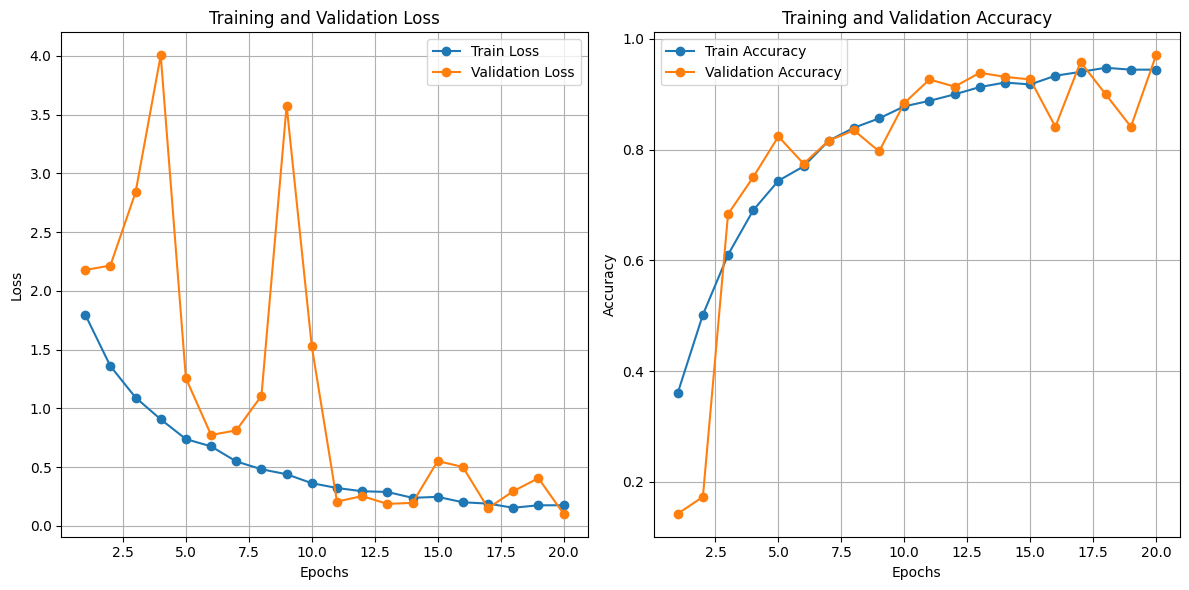

In [17]:
import matplotlib.pyplot as plt

# Training and Validation Loss and Accuracy Values
epochs = list(range(1, 21))
train_loss = [1.7984, 1.3596, 1.0917, 0.9060, 0.7381, 0.6759, 0.5477, 0.4812, 0.4387, 0.3626, 0.3217, 0.2940, 0.2879, 0.2379, 0.2462, 0.2001, 0.1889, 0.1533, 0.1745, 0.1745]
val_loss = [2.1775, 2.2157, 2.8386, 4.0059, 1.2558, 0.7734, 0.8120, 1.1065, 3.5778, 1.5270, 0.2056, 0.2530, 0.1862, 0.1951, 0.5510, 0.5010, 0.1492, 0.2944, 0.4055, 0.1020]

train_acc = [0.3601, 0.5016, 0.6100, 0.6904, 0.7437, 0.7696, 0.8160, 0.8394, 0.8563, 0.8780, 0.8880, 0.8997, 0.9129, 0.9210, 0.9176, 0.9333, 0.9403, 0.9477, 0.9443, 0.9443]
val_acc = [0.1421, 0.1727, 0.6834, 0.7502, 0.8236, 0.7744, 0.8162, 0.8347, 0.7967, 0.8839, 0.9266, 0.9136, 0.9387, 0.9313, 0.9266, 0.8412, 0.9582, 0.8997, 0.8412, 0.9703]

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Copyright 2024 by Andrey Ignatov. All Rights Reserved.

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor


class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=2, relu=False):

        super(UpsampleConvLayer, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):

        out = self.upconv(x)
        out = self.relu(out)

        return out


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class DeepCMorphSegmentationModule(nn.Module):

    def __init__(self, use_skips=False, num_classes=7):

        super(DeepCMorphSegmentationModule, self).__init__()

        net = models.efficientnet_b7(weights=None)

        self.return_nodes = {
            "features.2.0.block.0": "f1",
            "features.3.0.block.0": "f2",
            "features.4.0.block.0": "f3",
            "features.6.0.block.0": "f4",
        }

        self.encoder = create_feature_extractor(net, return_nodes=self.return_nodes)

        for p in self.encoder.parameters():
            p.requires_grad = True

        self.use_skips = use_skips

        self.upsample_1 = UpsampleConvLayer(1344, 512, 2)
        self.upsample_2 = UpsampleConvLayer(512, 256, 2)
        self.upsample_3 = UpsampleConvLayer(256, 128, 2)
        self.upsample_4 = UpsampleConvLayer(128, 64, 2)

        self.conv_1 = DoubleConv(992, 512)
        self.conv_2 = DoubleConv(544, 256)
        self.conv_3 = DoubleConv(320, 128)
        self.conv_4 = DoubleConv(64, 64)

        self.conv_segmentation = nn.Conv2d(64, 1, 3, 1, padding="same")
        self.conv_classification = nn.Conv2d(64, num_classes, 3, 1, padding="same")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        features = self.encoder(x)

        net = self.conv_1(torch.cat((self.upsample_1(features["f4"]), features["f3"]), dim=1))
        net = self.conv_2(torch.cat((self.upsample_2(net), features["f2"]), dim=1))
        net = self.conv_3(torch.cat((self.upsample_3(net), features["f1"]), dim=1))
        net = self.conv_4(self.upsample_4(net))

        predictions_segmentation = self.sigmoid(self.conv_segmentation(net))
        predictions_classification = self.sigmoid(self.conv_classification(net))

        return predictions_segmentation, predictions_classification


class DeepCMorph(nn.Module):

    def __init__(self, num_classes=41, dropout_rate=0.0,
                 freeze_classification_module=False, freeze_segmentation_module=True):

        super(DeepCMorph, self).__init__()

        self.num_classes = num_classes
        self.use_dropout = True if dropout_rate > 0 else False
        self.dropout = nn.Dropout(dropout_rate)

        # Defining nuclei segmentation and classification module
        self.model_preprocessing = DeepCMorphSegmentationModule()

        # Freezing the weights of the segmentation module
        for p in self.model_preprocessing.parameters():
            p.requires_grad = False if freeze_segmentation_module else True

        # Defining the DeepCMorph classification module

        # Using the standard Torchvision EfficientNetB7 implementation
        EfficientNetB7_backbone = models.efficientnet_b7(weights=None)
        self.return_nodes = {"flatten": "features"}

        self.encoder = create_feature_extractor(EfficientNetB7_backbone, return_nodes=self.return_nodes)

        # Changing the number of EfficientNet's input channels from 3 to 11:
        # 3 RGB + 1 nuclei segmentation + 7 nuclei classification feature maps
        self.encoder.features._modules['0'] = nn.Conv2d(11, 64, 3, stride=2, padding=1, bias=False)

        for p in self.encoder.parameters():
            p.requires_grad = False if freeze_classification_module else True

        # Defining the final fully-connected layer producing the predictions
        self.output = nn.Linear(2560, num_classes)

        self.output_41 = nn.Linear(2560, 41)
        self.output_32 = nn.Linear(2560, 32)
        self.output_9 = nn.Linear(2560, 9)

    def forward(self, x, return_features=False, return_segmentation_maps=False):

        nuclei_segmentation_map, nuclei_classification_maps = self.model_preprocessing(x)

        if return_segmentation_maps:
            return nuclei_segmentation_map, nuclei_classification_maps

        x = torch.cat((nuclei_segmentation_map, nuclei_classification_maps, x), dim=1)

        features = self.encoder(x)
        extracted_features = features["features"]

        if return_features:
            return extracted_features

        if self.use_dropout:
            extracted_features = self.dropout(extracted_features)

        if self.num_classes == 41:
            return self.output_41(extracted_features)

        if self.num_classes == 32:
            return self.output_32(extracted_features)

        if self.num_classes == 9:
            return self.output_9(extracted_features)

        else:
            return self.output(extracted_features)

    def load_weights(self, dataset=None, path_to_checkpoints=None):
        # Wrap model with DataParallel for multi-GPU compatibility (if needed)
        self = torch.nn.DataParallel(self)

        if dataset is None and path_to_checkpoints is None:
            raise Exception("Please provide either the dataset name or the path to a checkpoint!")

        # Set default paths based on dataset name if path_to_checkpoints is not specified
        if path_to_checkpoints is None:
            if dataset == "COMBINED":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Datasets_Combined_41_classes_acc_8159.pth"
            elif dataset == "TCGA":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Pan_Cancer_32_classes_acc_8273.pth"
            elif dataset == "TCGA_REGULARIZED":
                path_to_checkpoints = "pretrained_models/DeepCMorph_Pan_Cancer_Regularized_32_classes_acc_8200.pth"
            elif dataset == "CRC":
                path_to_checkpoints = "pretrained_models/DeepCMorph_NCT_CRC_HE_Dataset_9_classes_acc_9699.pth"
            else:
                raise Exception("Please provide a valid dataset name = {'COMBINED', 'TCGA', 'TCGA_REGULARIZED', 'CRC'}")

        # Load the model weights with map_location set to CPU
        checkpoint = torch.load(path_to_checkpoints, map_location=torch.device('cpu'))
        missing_keys, unexpected_keys = self.load_state_dict(checkpoint, strict=False)

        print("Model loaded, unexpected keys:", unexpected_keys)




In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the dataset
dataset_path = "/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K"  # Replace with your dataset path

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = DeepCMorph(num_classes=9)  # Adjust num_classes based on your dataset

# Choose a device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_epoch(model, train_loader, optimizer, classification_loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        classification_preds = model(images)  # Only return classification logits

        # Compute loss
        loss = classification_loss_fn(classification_preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(classification_preds, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


# Validation loop
def validate_epoch(model, val_loader, classification_loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Compute loss
            loss = classification_loss_fn(classification_preds, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(classification_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Training and validation
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, classification_loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy = validate_epoch(model, val_loader, classification_loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Testing the model
def test_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Store predictions and labels
            _, predicted = torch.max(classification_preds, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Evaluate the model
test_labels, test_preds = test_model(model, test_loader, device)

# Print classification report
from sklearn.metrics import classification_report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))


Epoch 1/20, Train Loss: 1.6832, Train Accuracy: 0.3904
Epoch 1/20, Val Loss: 2.1768, Val Accuracy: 0.1541
Epoch 2/20, Train Loss: 1.2113, Train Accuracy: 0.5671
Epoch 2/20, Val Loss: 2.1407, Val Accuracy: 0.1012
Epoch 3/20, Train Loss: 0.9458, Train Accuracy: 0.6661
Epoch 3/20, Val Loss: 1.0358, Val Accuracy: 0.6630
Epoch 4/20, Train Loss: 0.7937, Train Accuracy: 0.7137
Epoch 4/20, Val Loss: 28.7287, Val Accuracy: 0.7781
Epoch 5/20, Train Loss: 0.6937, Train Accuracy: 0.7602
Epoch 5/20, Val Loss: 0.5788, Val Accuracy: 0.8542
Epoch 6/20, Train Loss: 0.5424, Train Accuracy: 0.8142
Epoch 6/20, Val Loss: 110.6378, Val Accuracy: 0.6314
Epoch 7/20, Train Loss: 0.4842, Train Accuracy: 0.8331
Epoch 7/20, Val Loss: 0.8601, Val Accuracy: 0.8561
Epoch 8/20, Train Loss: 0.4888, Train Accuracy: 0.8402
Epoch 8/20, Val Loss: 0.5297, Val Accuracy: 0.8199
Epoch 9/20, Train Loss: 0.4318, Train Accuracy: 0.8548
Epoch 9/20, Val Loss: 0.7923, Val Accuracy: 0.8496
Epoch 10/20, Train Loss: 0.3705, Train Accu

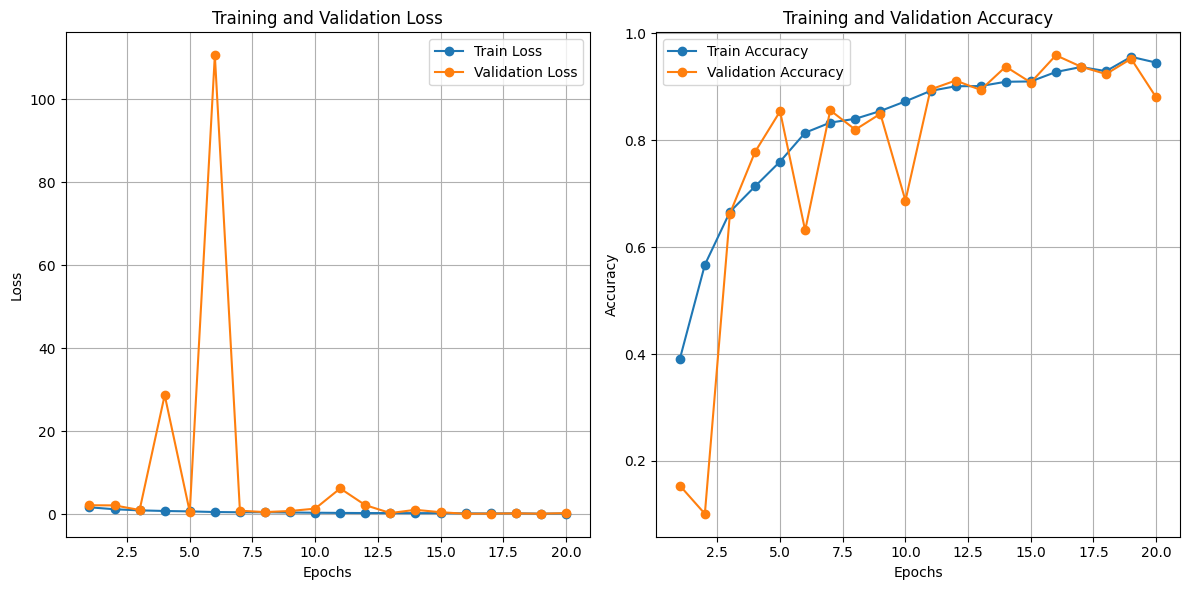

In [20]:
import matplotlib.pyplot as plt

# Data from the training and validation logs
epochs = list(range(1, 21))
train_loss = [1.6832, 1.2113, 0.9458, 0.7937, 0.6937, 0.5424, 0.4842, 0.4888, 0.4318, 0.3705,
              0.3304, 0.2940, 0.2902, 0.2716, 0.2775, 0.2165, 0.1953, 0.2236, 0.1491, 0.1865]
val_loss = [2.1768, 2.1407, 1.0358, 28.7287, 0.5788, 110.6378, 0.8601, 0.5297, 0.7923, 1.3581,
            6.2339, 2.2075, 0.2932, 1.0741, 0.5008, 0.1163, 0.1692, 0.2174, 0.1385, 0.2812]
train_acc = [0.3904, 0.5671, 0.6661, 0.7137, 0.7602, 0.8142, 0.8331, 0.8402, 0.8548, 0.8729,
             0.8924, 0.9011, 0.9015, 0.9095, 0.9101, 0.9278, 0.9371, 0.9294, 0.9562, 0.9453]
val_acc = [0.1541, 0.1012, 0.6630, 0.7781, 0.8542, 0.6314, 0.8561, 0.8199, 0.8496, 0.6871,
           0.8951, 0.9118, 0.8942, 0.9378, 0.9081, 0.9591, 0.9378, 0.9239, 0.9526, 0.8802]

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/20, Train Loss: 1.7247, Train Accuracy: 0.3788
Epoch 1/20, Val Loss: 2.1484, Val Accuracy: 0.1495
Epoch 2/20, Train Loss: 1.1922, Train Accuracy: 0.5854
Epoch 2/20, Val Loss: 2.0385, Val Accuracy: 0.2813
Epoch 3/20, Train Loss: 0.9390, Train Accuracy: 0.6763
Epoch 3/20, Val Loss: 3.1577, Val Accuracy: 0.7679
Epoch 4/20, Train Loss: 0.7863, Train Accuracy: 0.7274
Epoch 4/20, Val Loss: 1.8949, Val Accuracy: 0.7809
Epoch 5/20, Train Loss: 0.6970, Train Accuracy: 0.7608
Epoch 5/20, Val Loss: 0.7759, Val Accuracy: 0.7967
Epoch 6/20, Train Loss: 0.6207, Train Accuracy: 0.7869
Epoch 6/20, Val Loss: 4.4763, Val Accuracy: 0.7902
Epoch 7/20, Train Loss: 0.5441, Train Accuracy: 0.8112
Epoch 7/20, Val Loss: 0.4701, Val Accuracy: 0.8273
Epoch 8/20, Train Loss: 0.4586, Train Accuracy: 0.8372
Epoch 8/20, Val Loss: 0.4063, Val Accuracy: 0.8607
Epoch 9/20, Train Loss: 0.3817, Train Accuracy: 0.8701
Epoch 9/20, Val Loss: 3.2590, Val Accuracy: 0.8570
Epoch 10/20, Train Loss: 0.3461, Train Accurac

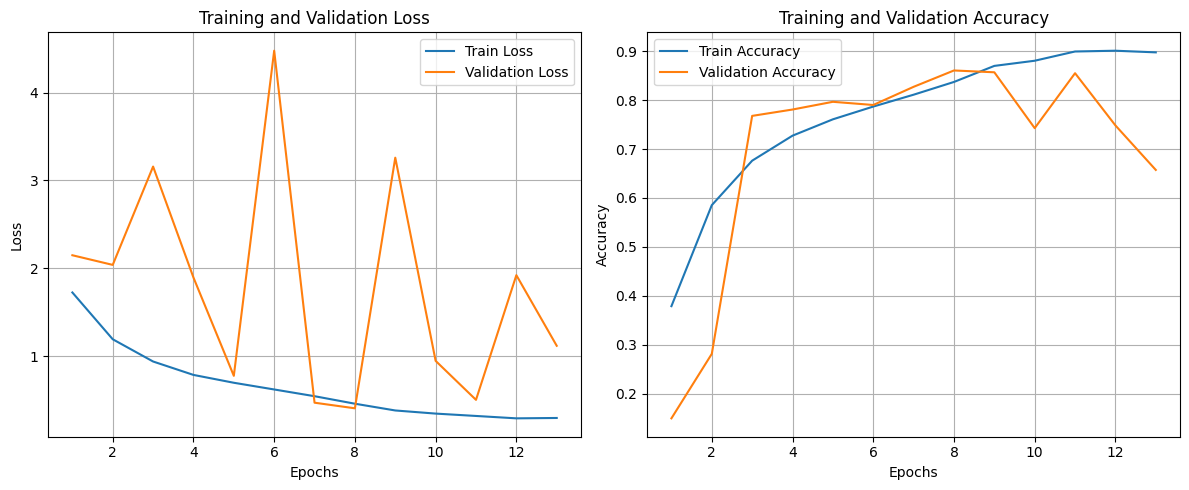

/tmp/ipykernel_23/2807589892.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Best model loaded for testing.


NameError: name 'test_model' is not defined

In [11]:
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to the dataset
dataset_path = "/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K"  # Replace with your dataset path

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.15 * len(full_dataset))   # 15% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = DeepCMorph(num_classes=9)  # Adjust num_classes based on your dataset

# Choose a device: CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Early stopping configuration
early_stopping_patience = 5  # Stop training if validation loss doesn't improve for 5 epochs
best_val_loss = float('inf')  # Initialize with infinity
patience_counter = 0  # Counter for early stopping

# Training loop
def train_epoch(model, train_loader, optimizer, classification_loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        classification_preds = model(images)  # Only return classification logits

        # Compute loss
        loss = classification_loss_fn(classification_preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(classification_preds, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


# Validation loop
def validate_epoch(model, val_loader, classification_loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Compute loss
            loss = classification_loss_fn(classification_preds, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(classification_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Storage for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and validation loop with early stopping
num_epochs = 20
for epoch in range(num_epochs):
    # Training step
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, classification_loss_fn, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation step
    val_loss, val_accuracy = validate_epoch(model, val_loader, classification_loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset counter if validation loss improves
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        patience_counter += 1  # Increment counter if no improvement
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training.")
            break

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded for testing.")

# Test the model
test_labels, test_preds = test_model(model, test_loader, device)

# Print classification report
from sklearn.metrics import classification_report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))


In [12]:
# Testing the model
def test_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            classification_preds = model(images)  # Only return classification logits

            # Store predictions and labels
            _, predicted = torch.max(classification_preds, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Test the model
test_labels, test_preds = test_model(model, test_loader, device)

# Print classification report
from sklearn.metrics import classification_report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       199
           1       1.00      1.00      1.00       143
           2       0.59      0.25      0.36        51
           3       0.77      0.94      0.84        98
           4       0.94      0.96      0.95       150
           5       0.74      0.85      0.79        87
           6       0.79      0.90      0.84       115
           7       0.81      0.40      0.54        52
           8       0.88      0.92      0.90       182

    accuracy                           0.88      1077
   macro avg       0.83      0.80      0.80      1077
weighted avg       0.88      0.88      0.87      1077

